In [47]:
import geopandas as gpd
import shapely
from libpysal.graph import read_parquet
from shapely import unary_union
import numpy as np
import pandas as pd

In [64]:
buildings_dir = '/data/uscuni-ulce/processed_data/buildings/'
graph_dir = '/data/uscuni-ulce/processed_data/neigh_graphs/'
morph_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
region_id = 151676

In [67]:
### add the connected structure characters
buildings  = gpd.read_parquet(buildings_dir + f"buildings_{region_id}.parquet")
buildings_q1 = read_parquet(graph_dir + f"building_graph_{region_id}.parquet")
clusters = pd.read_parquet(f'{morph_dir}tessellation_labels_morphotopes_{region_id}_75_0_None_None_False.pq')

In [74]:
buildings['morph'] = clusters
buildings = buildings[buildings.morph.str.split('_').str[-1] != '-1']

In [77]:
groups = buildings.groupby('morph')

In [78]:
group = groups.get_group('568_351')

In [82]:
group_graph = buildings_q1.subgraph(group.index)

In [84]:
%%time
connected_buildings = group.geometry.groupby(group_graph.component_labels).apply( lambda x: unary_union(x.values))
connected_buildings = connected_buildings.set_crs(epsg=3035).buffer(.1).normalize().make_valid()

CPU times: user 14.7 ms, sys: 1.06 ms, total: 15.7 ms
Wall time: 15.5 ms


In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree


group_area = connected_buildings.geometry.area
group_perimeter = connected_buildings.geometry.length
morph_data = pd.DataFrame({'area': group_area, 'per':group_perimeter})

# get the nearest buildings based on area, perimeter, eri
# vals = QuantileTransformer(subsample=None).fit_transform(morph_data)
vals = StandardScaler().fit_transform(morph_data)
tree = KDTree(vals)
dists, idxs = tree.query(vals, k=6)

In [113]:
from shapely import get_coordinates
coords, indx = get_coordinates(connected_buildings, return_index=True)
np.unique(indx).shape

(134,)

In [114]:
xs, ys = connected_buildings.centroid.x.values, connected_buildings.centroid.y.values
centroids = np.vstack((xs[indx], ys[indx])).T

In [115]:
centred_coords = coords - centroids

In [116]:
centred_connected_buildings = pd.DataFrame(centred_coords).groupby(indx).apply(shapely.Polygon)

In [117]:
centred_connected_buildings

0      POLYGON ((-11.822924769483507 8.88769317464903...
1      POLYGON ((-15.363977519795299 8.84606348816305...
2      POLYGON ((-22.54852515924722 13.80820921063423...
3      POLYGON ((-11.752280227839947 14.3937058388255...
4      POLYGON ((-22.236094499006867 15.8802797393873...
                             ...                        
129    POLYGON ((-10.65860362071544 0.836839281953871...
130    POLYGON ((-20.245212392881513 16.0112040885724...
131    POLYGON ((-3.5264434656128287 -1.1963195418938...
132    POLYGON ((-8.310765656642616 -2.78414730634540...
133    POLYGON ((-5.134028704836965 1.360831957776099...
Length: 134, dtype: object

In [118]:
connected_buildings

component labels
0      POLYGON ((5296735.999 3618470.222, 5296736 361...
1      POLYGON ((5296555.176 3618297.517, 5296555.177...
2      POLYGON ((5296193.729 3618426.965, 5296193.73 ...
3      POLYGON ((5296648.686 3618590.453, 5296648.687...
4      POLYGON ((5296590.005 3618411.849, 5296590.006...
                             ...                        
129    POLYGON ((5296576.716 3618851.898, 5296576.717...
130    POLYGON ((5296259.069 3618501.512, 5296259.069...
131    POLYGON ((5296335.982 3619252.568, 5296335.982...
132    POLYGON ((5296498.67 3618235.342, 5296498.671 ...
133    POLYGON ((5296557.189 3618323.33, 5296557.189 ...
Length: 134, dtype: geometry

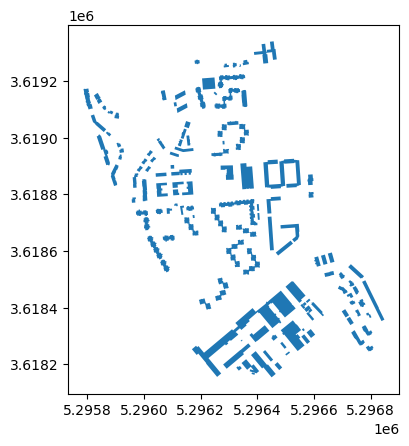

In [159]:
ax = gpd.GeoSeries(connected_buildings, name='geometry').plot()
# gpd.GeoSeries(connected_buildings, name='geometry').loc[[2, 130]].plot(color='red', ax=ax)

<Axes: >

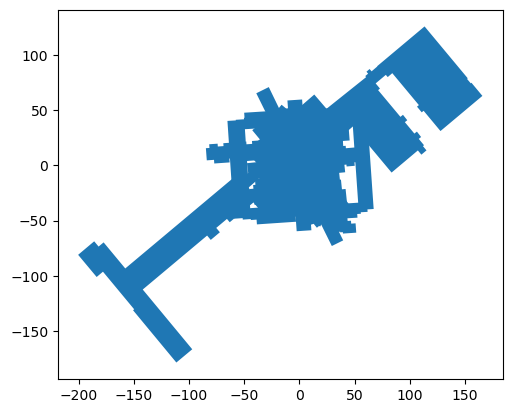

In [120]:
gpd.GeoSeries(centred_connected_buildings, name='geometry').plot()

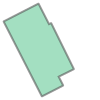

In [125]:
centred_connected_buildings.iloc[idxs[0, 0]]

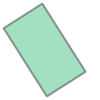

In [128]:
centred_connected_buildings.iloc[idxs[0, -1]]

In [207]:
dists, argmins = [], []
for i in idxs[:, 0]:
    hd = shapely.hausdorff_distance(centred_connected_buildings.iloc[idxs[i, 0]], centred_connected_buildings.iloc[idxs[i, 1:]])
    dists.append(hd.min())
    argmins.append(hd.index[hd.argmin()])

In [208]:
i = 5
dists[i], argmins[i]

(np.float64(6.8326267232952125), np.int64(9))

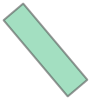

In [209]:
connected_buildings[i]

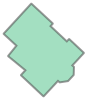

In [210]:
connected_buildings[argmins[i]]